# What does *self* refer to in the self-attention?

"Self-attention" mechanism, like other attention mechanisms introduces some weights. However, the key difference is how the weights are defined. Before getting into that, let's get an understanding about what **"self"** refers to in the term **self-attention**. To do so, we go through a simple example.

Let's assume that we want to assess a car company's performance by looking at the price of the cars it manufactures over a 10-year period.

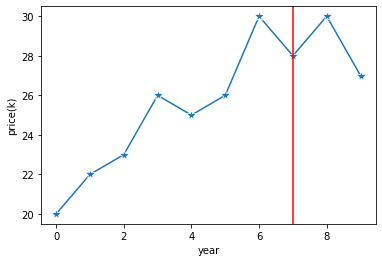

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

year=range(10)
price=[20,22,23,26,25,26,30,28,30,27]
price_history = pd.DataFrame(zip(year,price), 
                             columns=['year','price(k)'])
ax=sns.lineplot(x='year', y='price(k)', data=price_history, marker="*", markersize=10)
_=ax.axvline([7], color='red')

The price trend shown above looks noisy. While it is upward overall, for example at year 7 the price drops from year 6. If we want to look at the trend globally this noise is better to be removed. In other words, if we want to only look at the year 7, which shows a price drop, and still be able to make a good judgment about the overall performance of the company, we should ignore the local noise causing the price drop compared to the last year.

We may do that by smoothing the trend by applying a low pass filter, like moving average. Let's take the following low pass filter, which is also called exponential moving average:

$$\hat{y}_{t}= (1-\alpha) \times \hat{y}_{t-1} + \alpha\times y_t $$

so at each year $t$, a new representation for the price $y_t$ is called $\hat{y}_{t}$, a weighted mean of the prices in the preceding years.

Before relating this to attention mechanism, let's take a look at the result of this filtering:


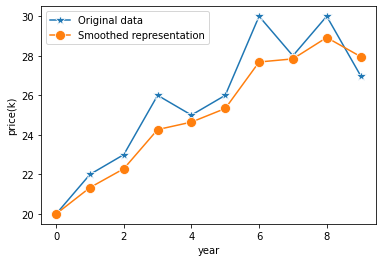

In [3]:
price_history['price_smoothed(k)'] = price_history['price(k)'].ewm(alpha=.5).mean() ## ewm applies the formula above

ax=sns.lineplot(x='year', y='price(k)', data=price_history, marker="*", markersize=10, label='Original data')
_=sns.lineplot(ax=ax, x='year', y='price_smoothed(k)', data=price_history, 
               marker="o", markersize=10, label='Smoothed representation')

Now, what we did above could also be named *attention*: for each observation in the 10-year sample, we calculate a new representation which is based on weighing on other observations. Through $\alpha$ we decide how much to *attend* to the previous values and the current one.

In this case the only context we have used to do the attention is time; that is, for each observation the attention is applied based on the time the other observations are made. In practice we usually have more information to do the smoothing.

## Adding context

In the example above, we contextualized each observation in the 10-year sample. The context was time. In a more general scenario, each observation could be associated with more context information, which could also be named as attributes. 

Assume that the car company in our example only makes two car models A and B, and the cars are only in two colors black and blue. Let's add these information to the price history:

In [5]:
price_history['color']=['black', 'black', 'black','blue', 'black','blue','black','blue','black','blue']
price_history['model']=['A','A','A','A','A','A','B','B','A','B']

Now we have more contexts to consider for the performance assessment; let's visualize the price trend for each model and color to get an intuition how these extra contexts help us to interpret the prices:

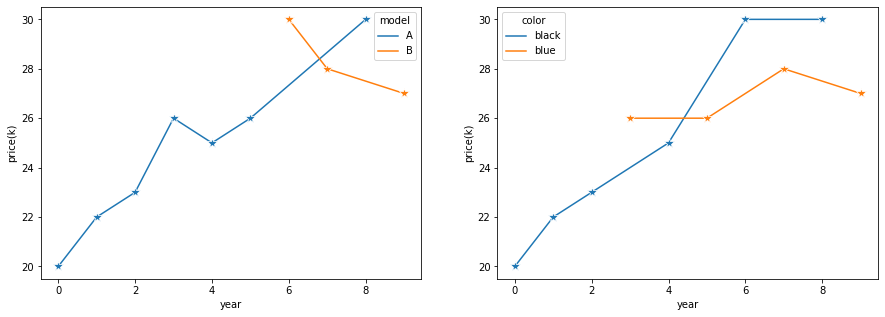

In [6]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
_=sns.lineplot(ax=ax[0], x='year', y='price(k)', data=price_history, hue='model',marker="*", markersize=10)
_=sns.lineplot(ax=ax[1], x='year', y='price(k)', data=price_history, hue='color',marker="*", markersize=10)

Now, if we want to look at a certain year and still have a good assessment about the prices, we shall take the context information into account. Do you think we could look at the price at year 9, and confidently conclude that the cars' price increased over time? I would say no, because the price at year 9 is for model B and the data suggests that model B has actually a downward price trend. 

Therefore, it makes sense to use this context information for a good interpretation of the prices. Obviously the price increase cannot be generalized to both models and even colors equally. So, if we want to interpret the price at a certain year, we need to look at the price history for similar cars in terms of color and model.

Towards that goal, we need to find a *similarity* between the cars based on the model and color info (context info). 

## Similarity score

One way to measure similarity between two numerical vectors is dot product. In our example, we first need to represent color and model with numbers, which can be done by one-hot-encoding:

In [10]:
price_history_ohe = pd.get_dummies(price_history)
price_history_ohe.head()

,year,price(k),price_smoothed(k),color_black,color_blue,model_A,model_B
0,0,20,20.000000,1,0,1,0
1,1,22,21.333333,1,0,1,0
2,2,23,22.285714,1,0,1,0
3,3,26,24.266667,0,1,1,0
4,4,25,24.645161,1,0,1,0


Now for each year the car is represented by a vector $y$ of length four (to contain model and color information):

$$y_{0},..., y_{9}$$

where $y_{t}$ represents the context vector for the car at year $t$.
Now, we can utilize the dot product on the context information between the cars in our sample set. For each pair of cars at year $m,n$, the similarity score is:
$$similarity\_score(y_{m},y_{n}) = y_{n}\cdot y_{m} $$

It is very useful to normalize the similarity score. Thus, we take the normalized version of dot product by mapping the values between 0 and 1:

$$ w_{m,n} = (y_{n}\cdot y_{m}) / \sum_{i,j=0}^{9} (y_{i}\cdot y_{j})$$

So we could use $w_{m,n}$ as the measure of similarity.


## New representation using the context info

Let's do not forget what the end goal is: we want to incorporate more information than only time to interpret the prices. In other words, a new price representation is not based on time but the context info. Thus, the ultimate goal is still as follows:
$$\hat{y}_{t} = f(y_t)$$
where through $f$ we find the new representation. We consider $f$ to be a reweighing process.

In the previous section we argued how the similarity based on context info could help. For each year $q$, we do the following:


$\hspace{7cm} y_q \xrightarrow{\text{dot product}}  [y_{0}, ..., y_{k}, ... , y_{9}] \xrightarrow{\text{normalizing}} [w_{0,q},...,w_{k,q},...,w_{9,q}]$
                                    
We intentionally used $q$ as index to start with introducing a term *query*, which is a common term you face a lot in the context of self-attention. 

**So, the data from each year *queries* other data what the similarity scores would be**.

THen, to find a new representation $\hat{y}_{q}$ we have:

$$\hat{y}_{q} = w_{0,q}y_{0}+...+w_{k,q}y_{k}+...+w_{9,q}y_{9}$$



*If we consider the 10-year price info as one sample, what we just did is that each component of the sample attends to other components of the **same** sample to make a new representation. You might now have a glimpse of why we use the term **self**. Each sample attends to itself to get it's new representation.*

In [14]:
price_history_ohe['similarity_with_year7']=0
context_only = price_history_ohe[['color_black','color_blue','model_A','model_B']]
context_only_year_7 = context_only.iloc[7,:]
for row_index, row_value in context_only.iterrows():
    price_history_ohe.loc[row_index,'similarity_with_year7'] = row_value.dot(context_only_year_7)
price_history_ohe

,year,price(k),price_smoothed(k),color_black,color_blue,model_A,model_B,similarity_with_year7
0,0,20,20.000000,1,0,1,0,0
1,1,22,21.333333,1,0,1,0,0
2,2,23,22.285714,1,0,1,0,0
3,3,26,24.266667,0,1,1,0,1
4,4,25,24.645161,1,0,1,0,0
5,5,26,25.333333,0,1,1,0,1
6,6,30,27.685039,1,0,0,1,1
7,7,28,27.843137,0,1,0,1,2
8,8,30,28.923679,1,0,1,0,0
9,9,27,27.960899,0,1,0,1,2
